In [2]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from utils import *
from AnalyseDefects import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [3]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

STEP 1: Using window sizes

In [4]:
LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [5]:
N = 2

def_arr, var_counts, dens_fluc, av_counts, av_def = ad.get_arrays_av(Ndataset=N, return_av_counts=True, use_merged=True)
act_list = ad.act_list[0]
av_counts_av = np.mean(av_counts, axis=0)
var_counts_av = np.mean(var_counts, axis=0)
dens_fluc_av = np.mean(dens_fluc, axis=0)
windows = ad.window_sizes[0]

av_dens = av_counts_av / (np.pi * (windows**2)[:,None,None])
var_counts_norm = var_counts_av / (np.pi * (windows**2)[:,None,None])

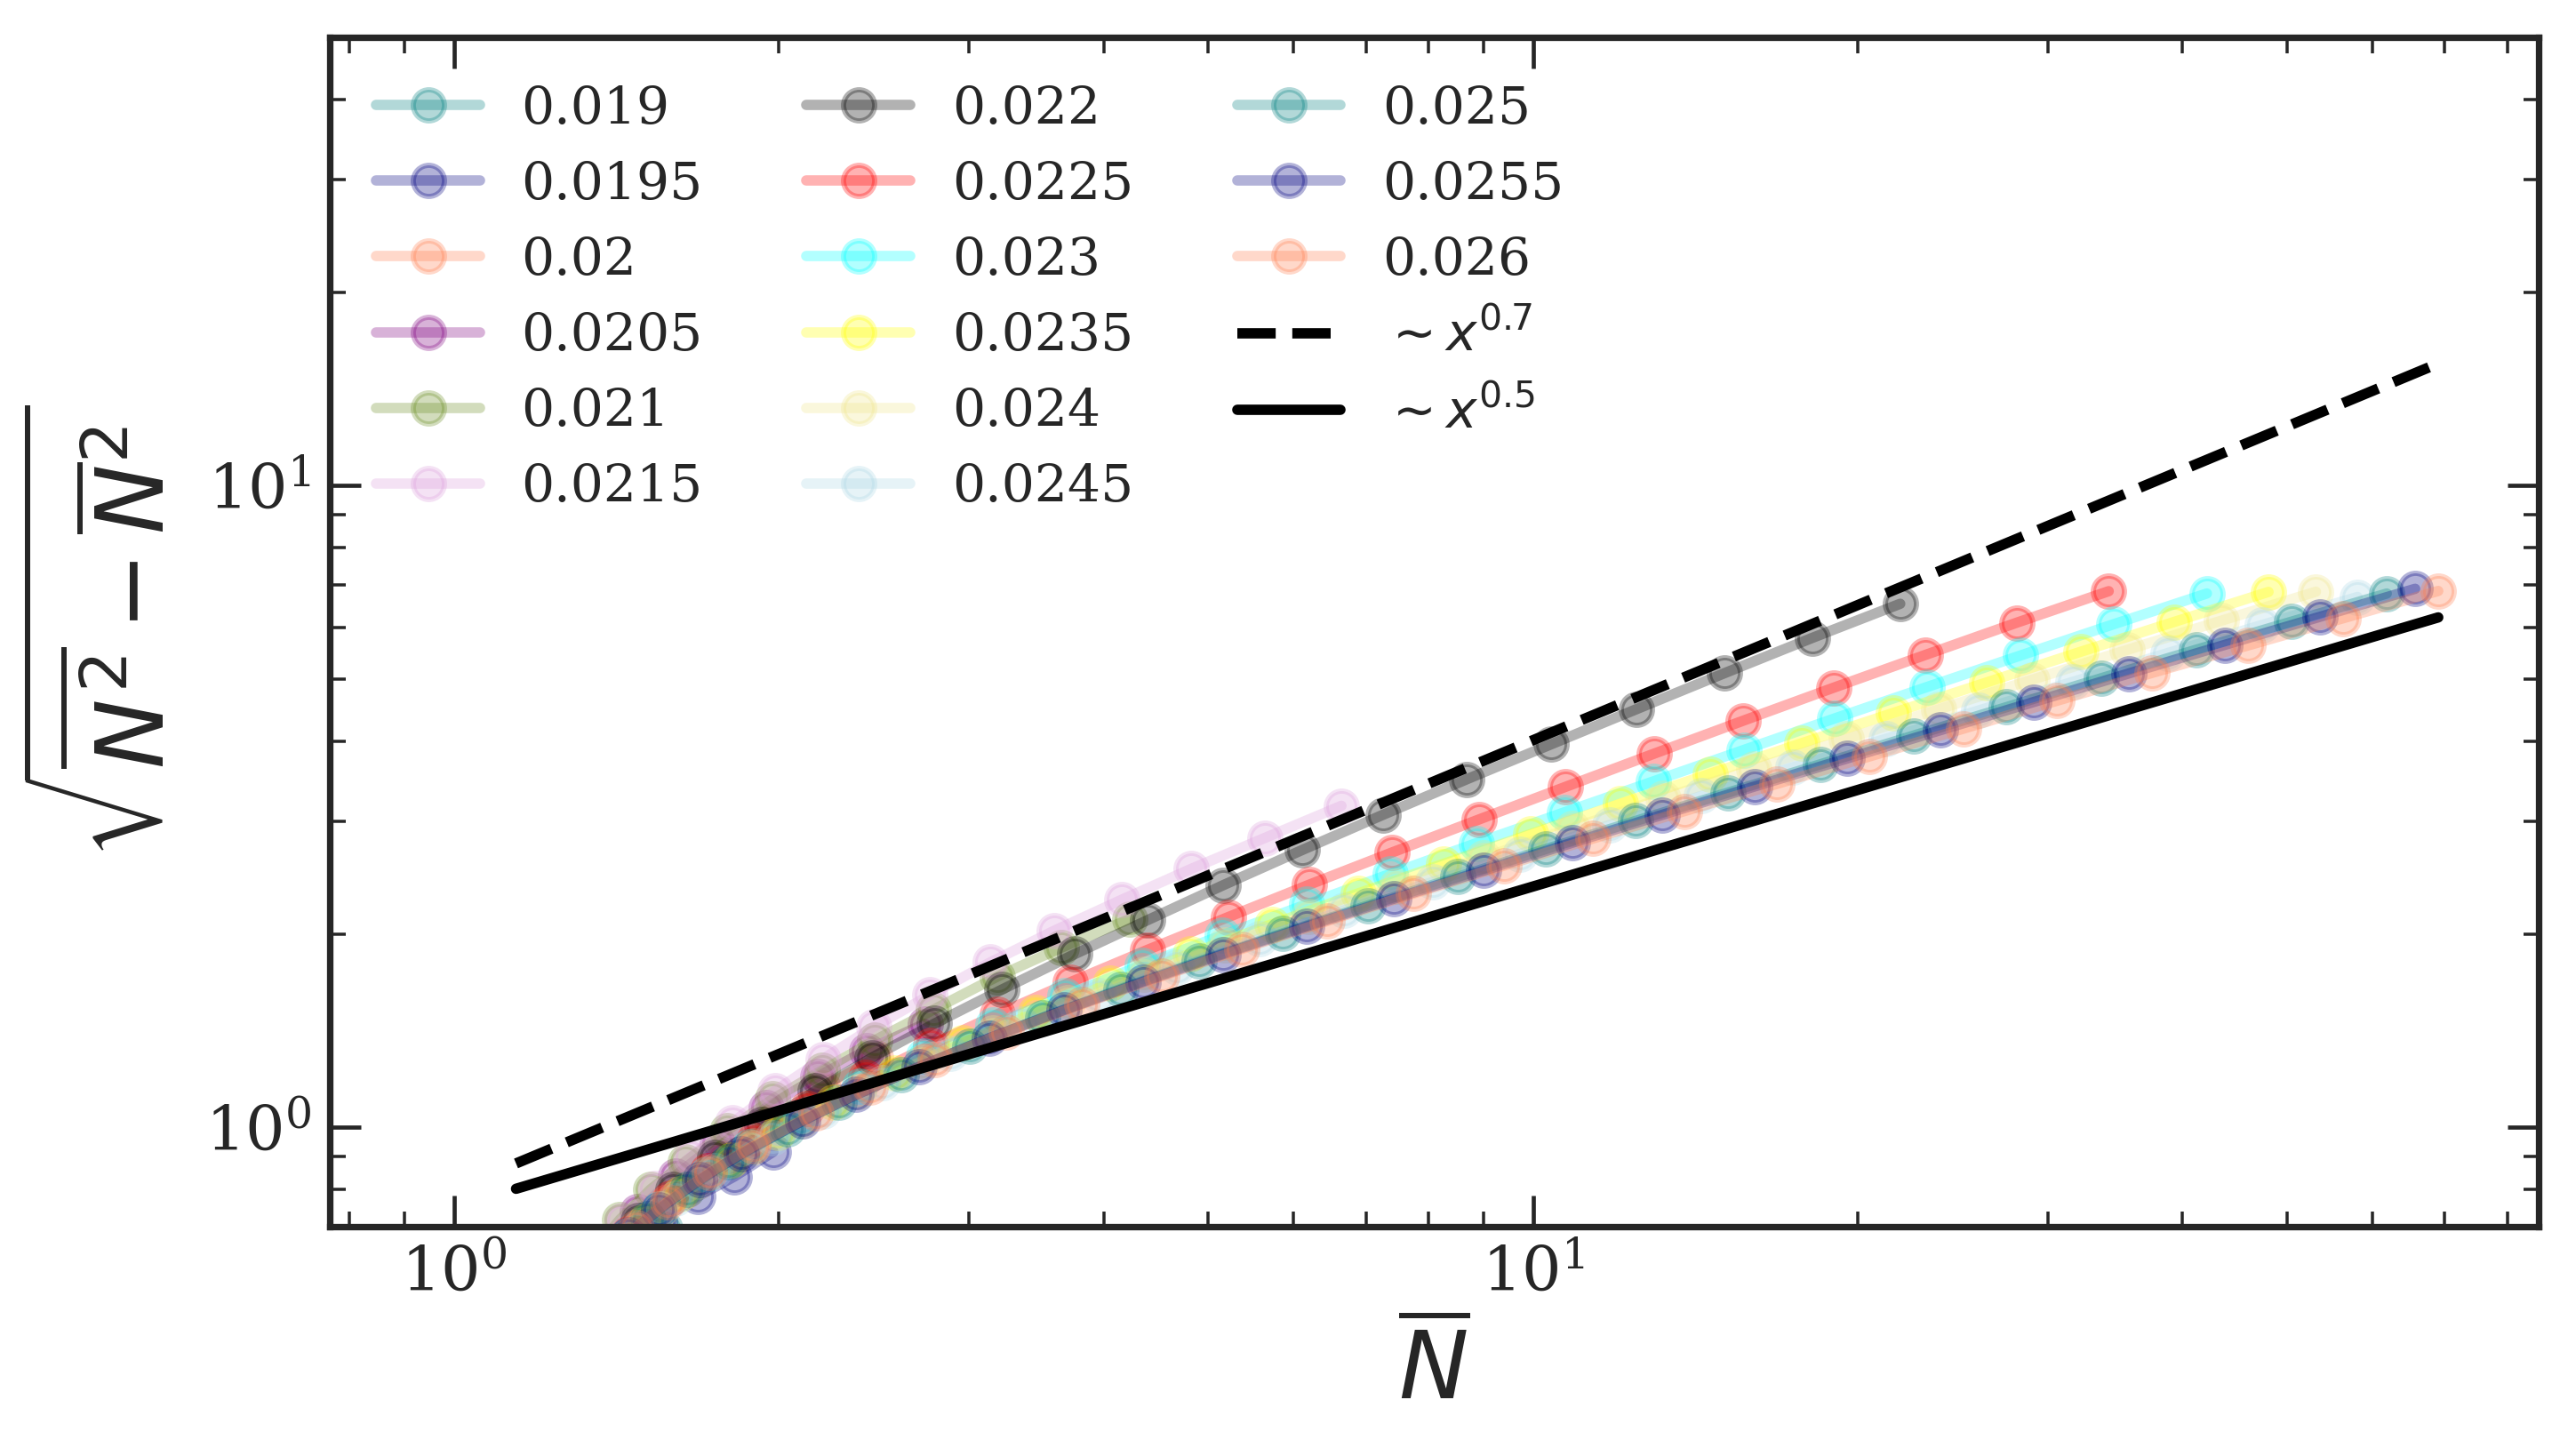

In [36]:
fig, ax = plt.subplots(figsize=(7,4))
density=False
for i, act in enumerate(act_list[:15]):

    if density:
        ax.plot(av_dens[10:,i,0], np.sqrt(var_counts_norm[10:,i,0]), label=f'{act}', marker='.', alpha=.3)
    else:
        ax.plot(av_counts_av[:,i,0], np.sqrt(var_counts_av[:,i,0]), label=f'{act}', marker='o', alpha=.3)


ax.plot(av_counts_av[:,i,0], 0.8*av_counts_av[:,i,0]**0.7, label=r'$\sim x^{0.7}$', color='black', linestyle='--')
ax.plot(av_counts_av[:,i,0], 0.75*av_counts_av[:,i,0]**0.5, label=r'$\sim x^{0.5}$', color='black', linestyle='-')

ax.set_xlabel(r'$\overline{N}$')
ax.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
ax.set_ylim(.7,50)
ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')

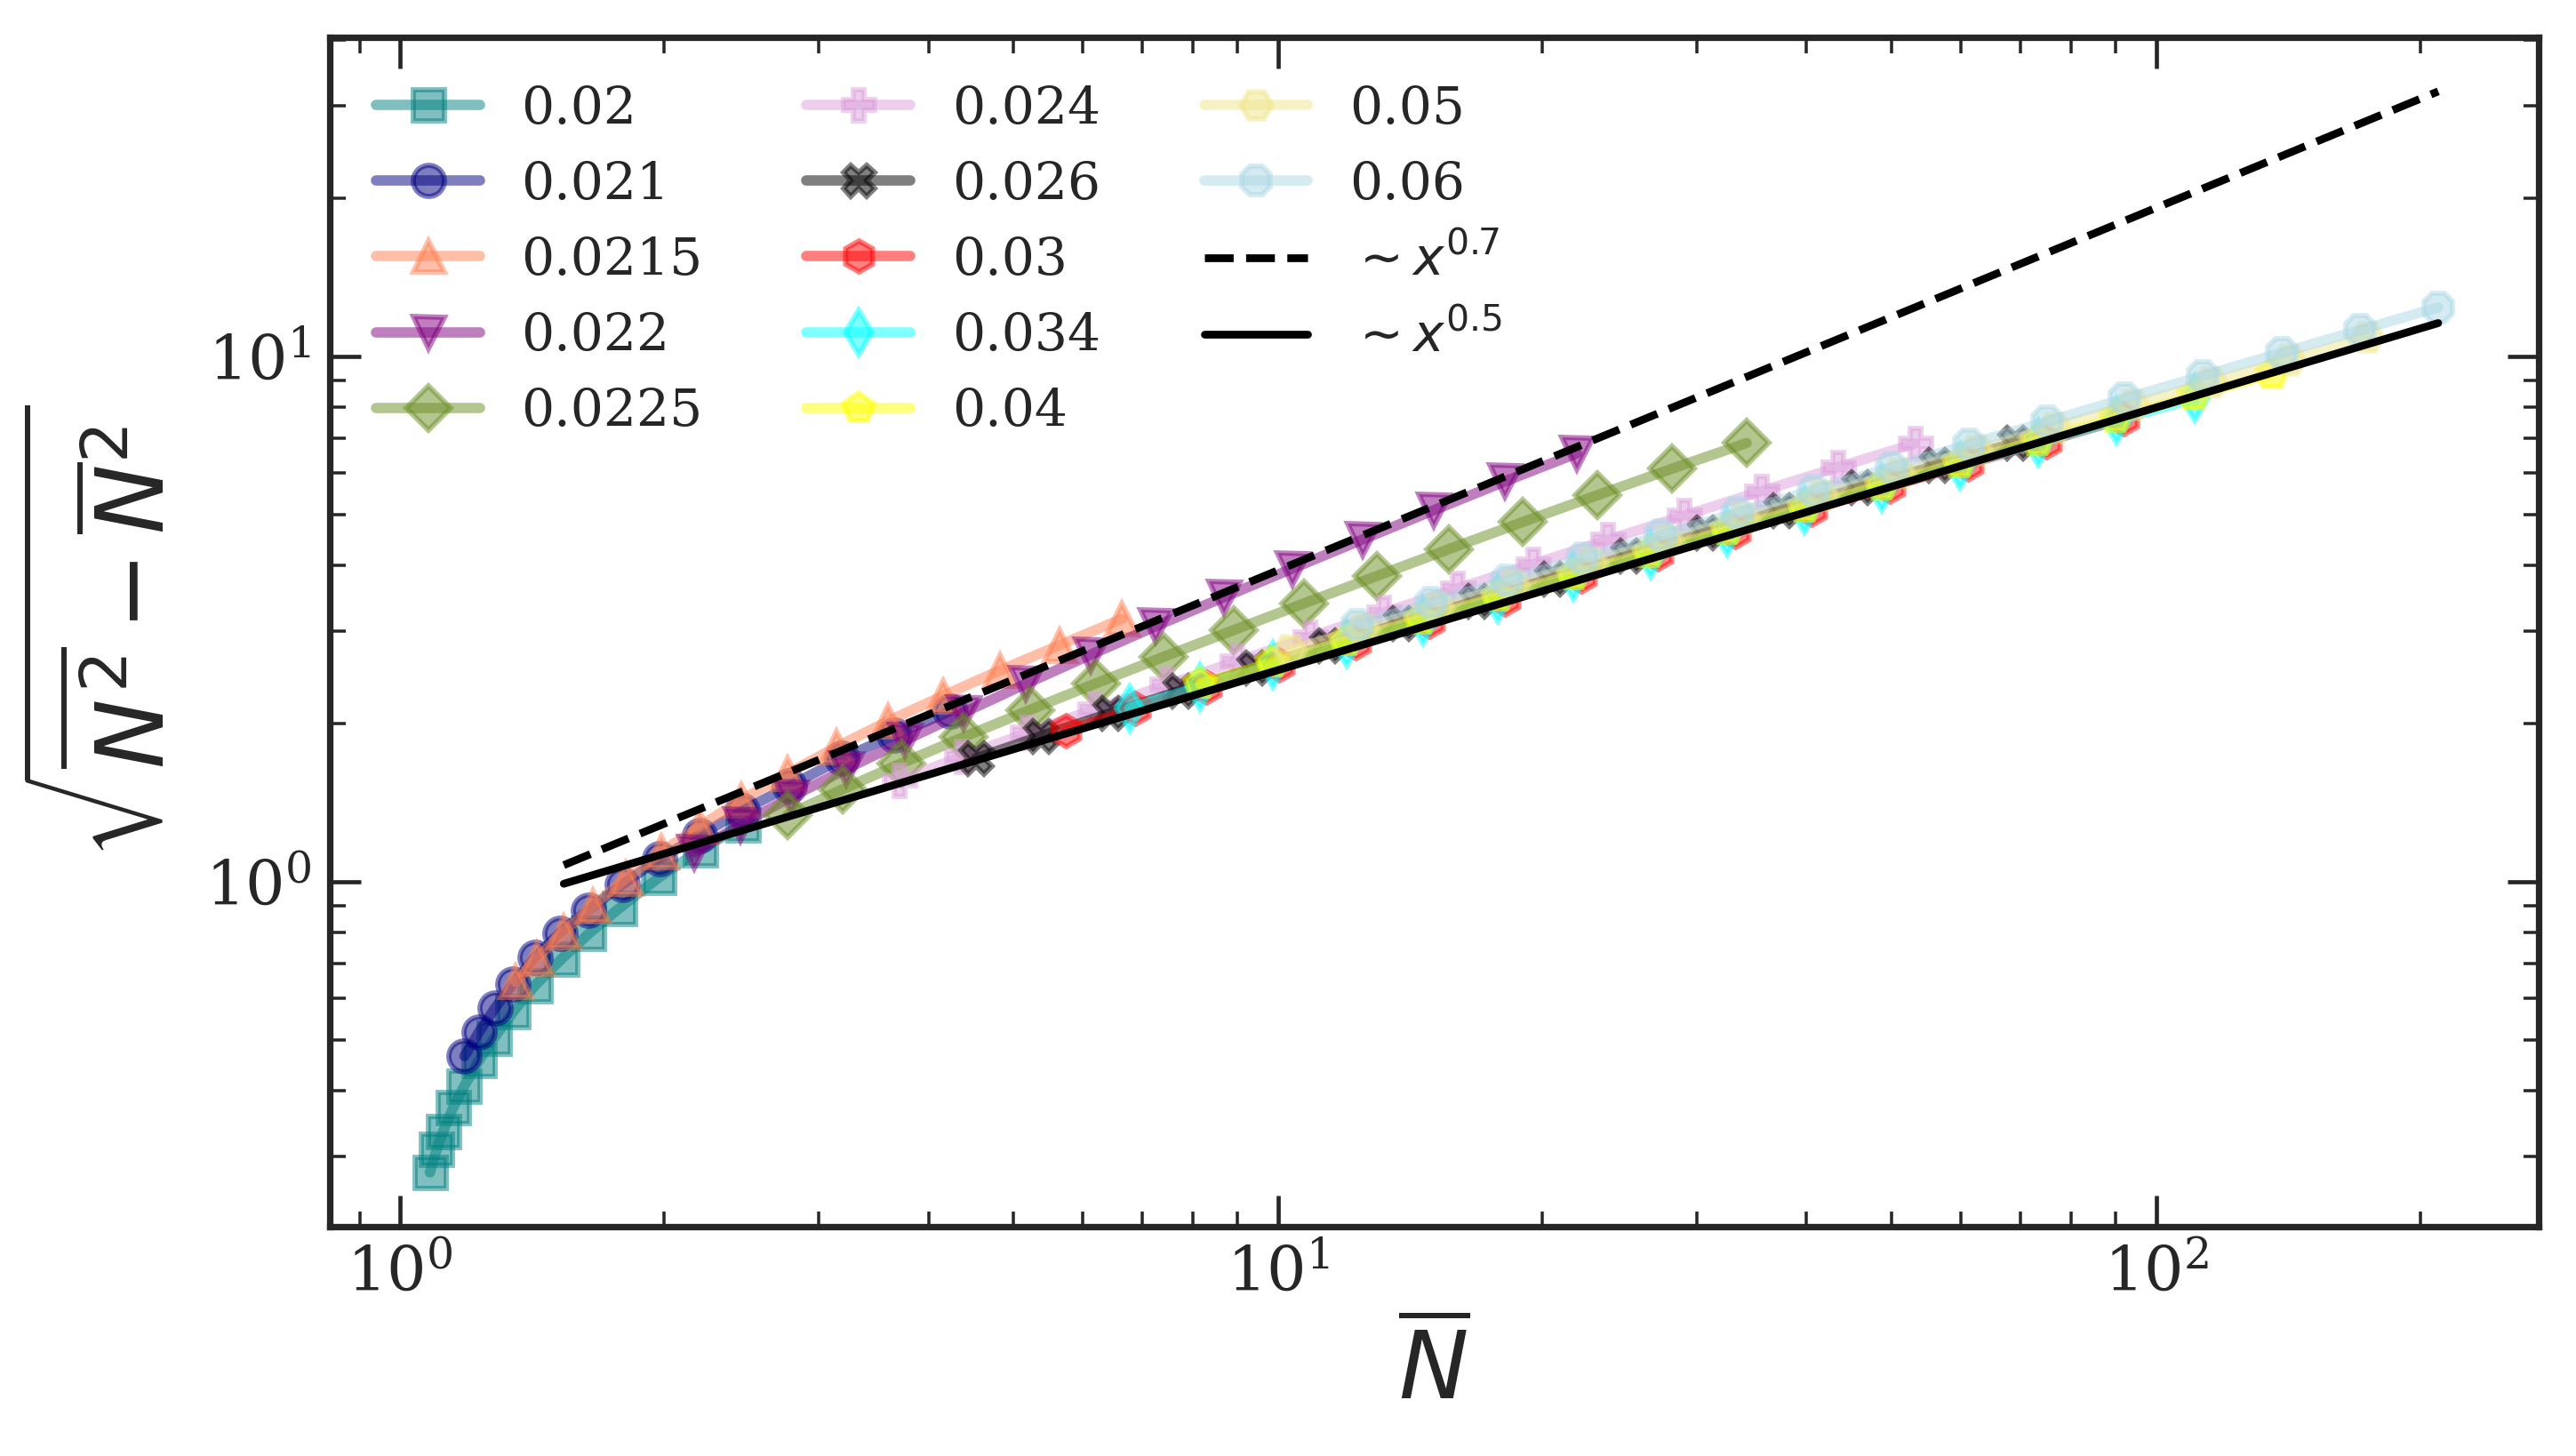

In [41]:
fig, ax = plt.subplots(figsize=(7,4))
min_window_idx = 15
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
for i, act in enumerate(acts_to_plot):

    idx = act_list.index(act)
    ax.plot(av_counts_av[min_window_idx:,idx,0], np.sqrt(var_counts_av[min_window_idx:,idx,0]),\
             label=f'{act}', marker=marker_shape[i], alpha=.5)

ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.69, label=r'$\sim x^{0.7}$', color='black', lw=1.5, linestyle='--')
ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.5,label=r'$\sim x^{0.5}$', color='black', lw=1.5, linestyle='-')


ax.set_xlabel(r'$\overline{N}$')
ax.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
#ax.set_ylim(.5,8)
#ax.set_xlim(1,100)
ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')


STEP 2: Using susceptibilities

In [11]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

from AnalyseDefectsAll import AnalyseDefectsAll as AnDef
adaa = AnDef(system_size_list)

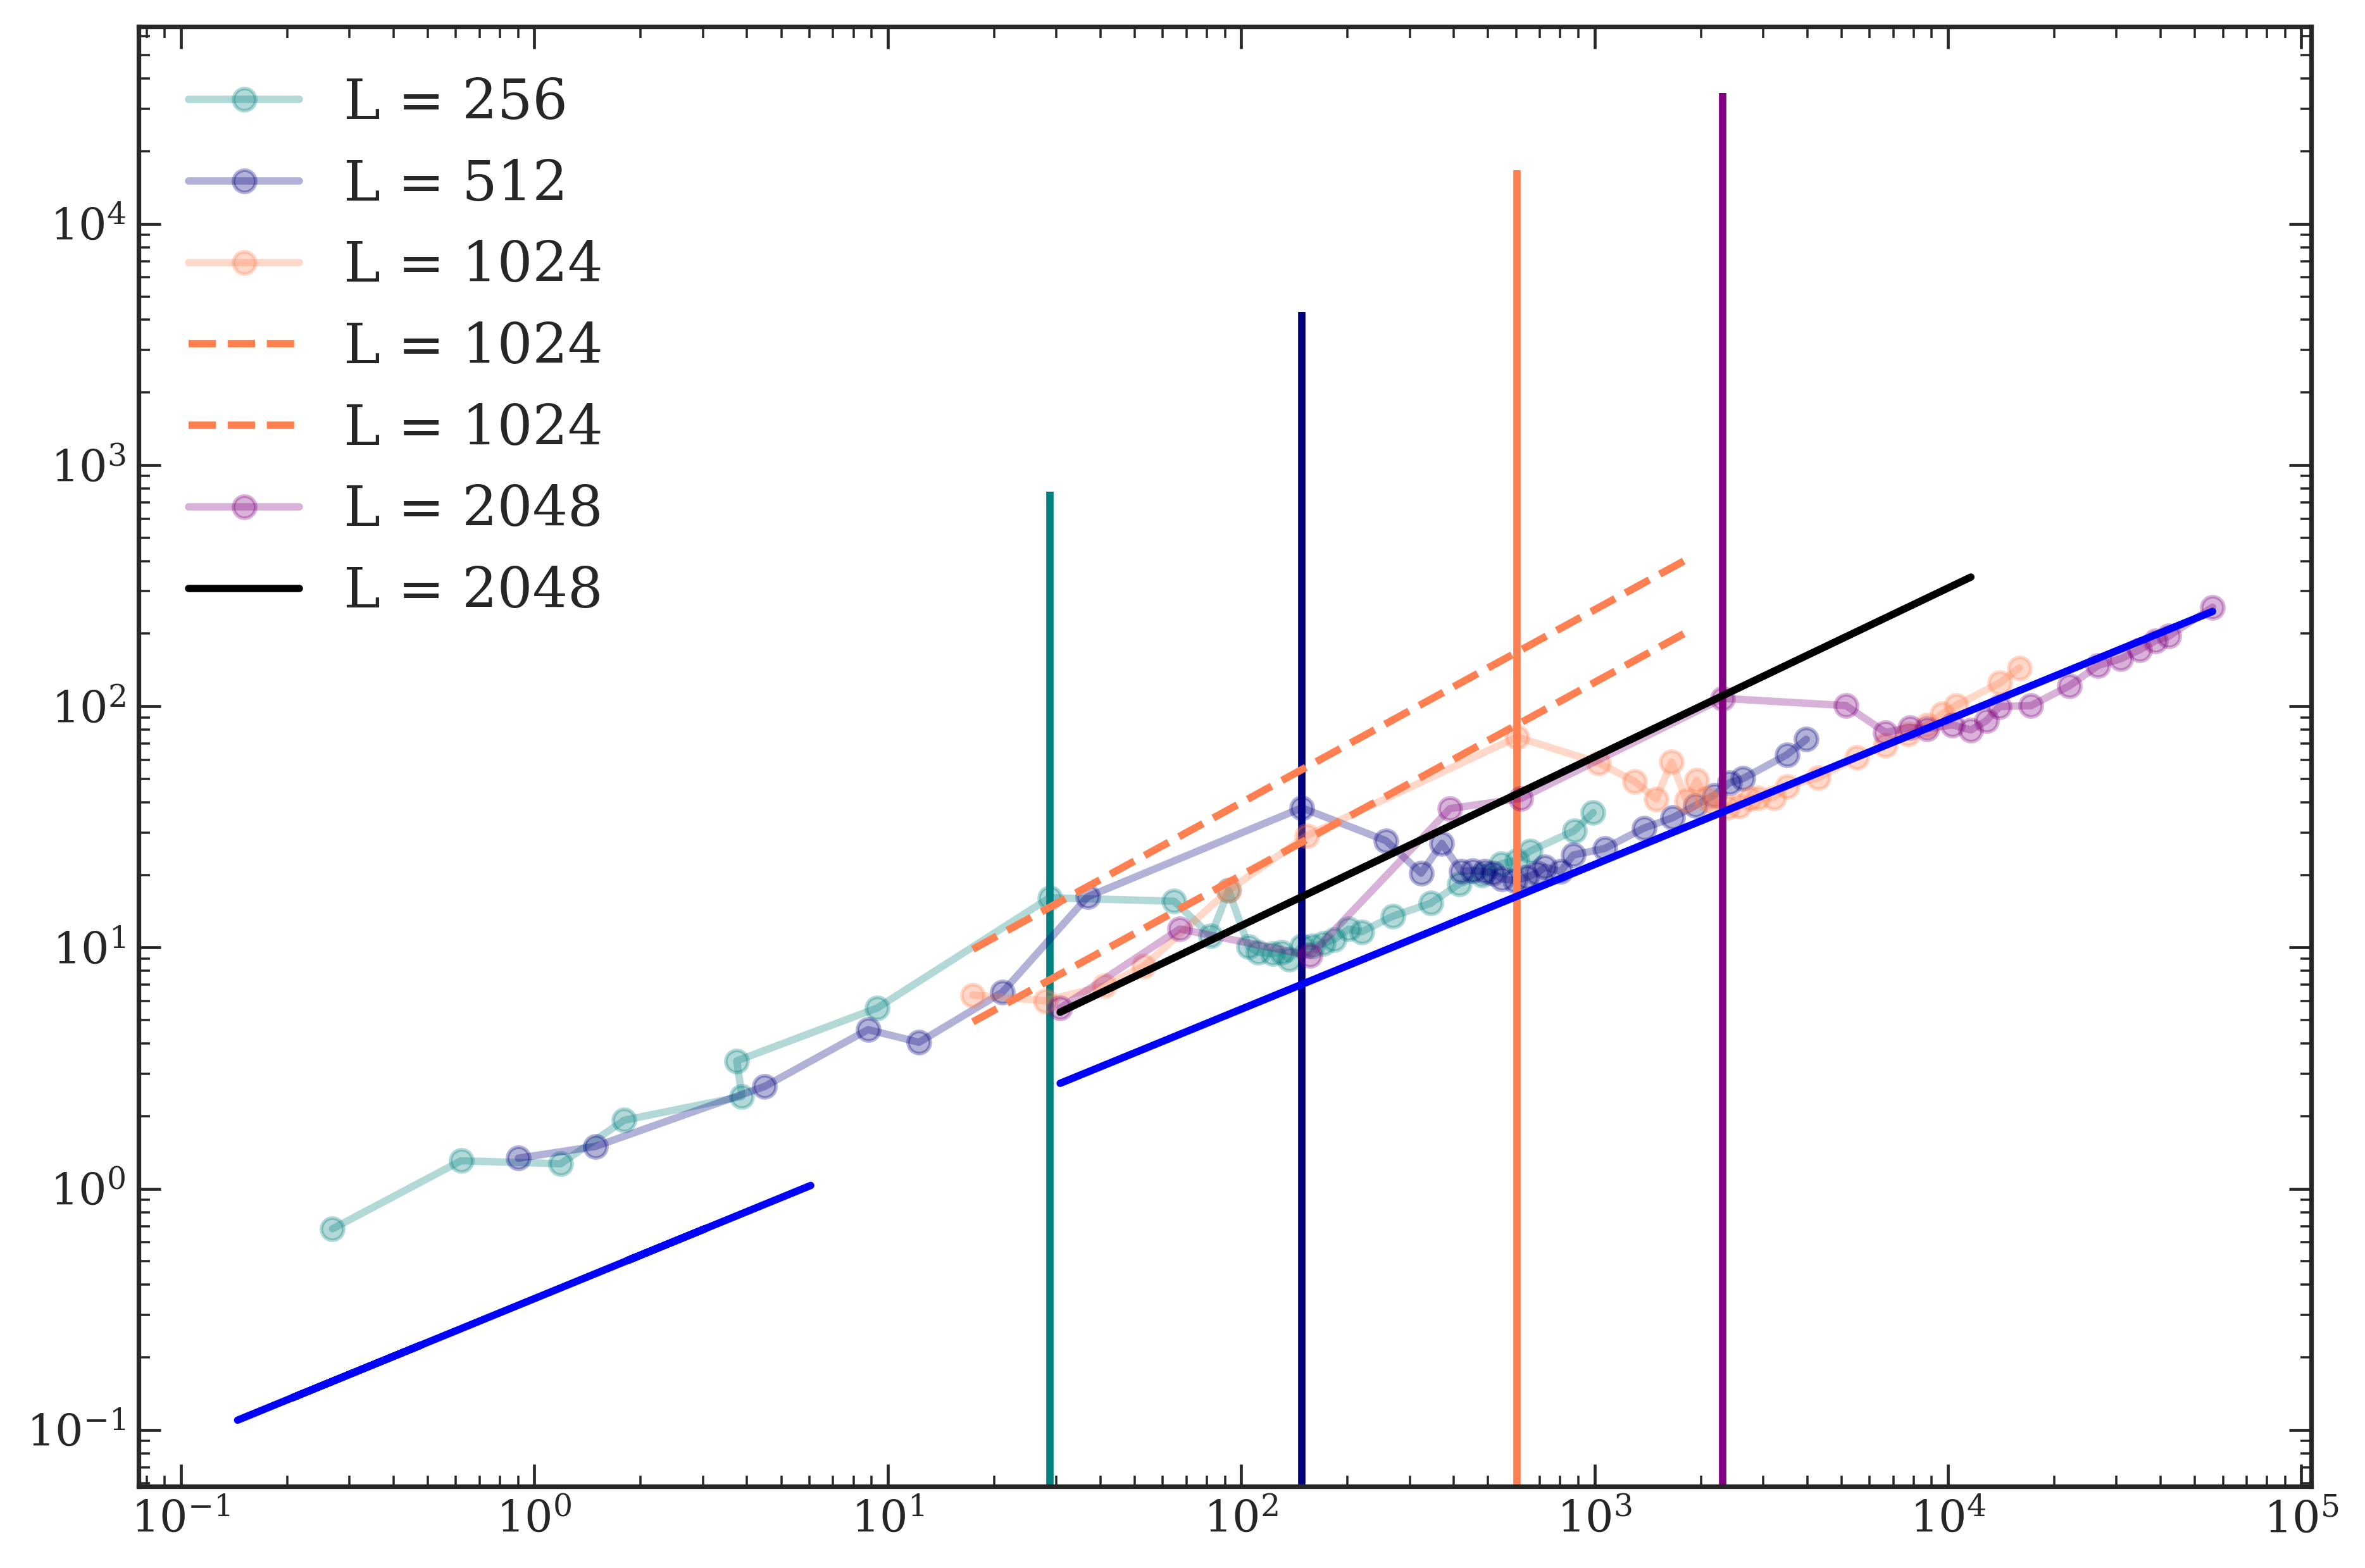

In [12]:
fig, ax = plt.subplots()

act = 0.022
density = False
for N, act_list in enumerate(ada.act_list):

    LX = ada.LX[N]
    act_idx = act_list.index(act)
    av_def = ada.get_av_defects(ada.LX[N], density = density)[1] #[act_idx,:]
    sus = ada.get_binder_susceptibility(ada.LX[N])[1]

    sus_scaled = sus[:,0] * av_def[:,0] #* LX**2
    sus_std = np.sqrt(sus_scaled)

    #ax.plot(av_def[:,0], sus[:,0] * av_def[:,0], 'o-', label = f'L = {ada.LX[N]}')
    ax.plot(av_def[:,0], sus_std, 'o-', label = f'L = {ada.LX[N]}', alpha=.3)
    ax.vlines(av_def[act_idx,0], 0, 3 * sus[act_idx,0] * av_def[act_idx,0],color = f'C{N}', linestyles='solid')
    
    a1 = np.max(np.diff(sus_scaled)[1] / np.diff(av_def[:,0])[1])
    if N == 2:
        ax.plot(av_def[:12,0],  1 * av_def[:12,0]**0.8, '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
        ax.plot(av_def[:12,0],  .5 * av_def[:12,0]**0.8, '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
   
    if N == 3:
        ax.plot(av_def[:12,0],  .49 * av_def[:12,0]**0.7, '-', color = f'black', label = f'L = {ada.LX[N]}')
        #ax.plot(av_def[:12,0],  1.7 * av_def[:12,0]**0.6, '-', color = f'k', label = f'L = {ada.LX[N]}')
        pass
        #ax.plot(av_def[10:,0], 0.6 * sus_std[10] + 8 * av_def[10:,0], '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
  #  print(np.diff(sus_scaled)[0] / np.diff(av_def[:,0])[0])
ax.plot(av_def,.35*av_def**0.6, 'b-')
ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend()